# 作业2-年收入判断

## 项目描述
二元分类是机器学习中最基础的问题之一，在这份教学中，你将学会如何实作一个线性二元分类器，来根据人们的个人资料，判断其年收入是否高于 50,000 美元。我们将以两种方法: logistic regression 与 generative model，来达成以上目的，你可以尝试了解、分析两者的设计理念及差别。
实现二分类任务：
* 个人收入是否超过50000元？

## 数据集介绍
这个资料集是由UCI Machine Learning Repository 的Census-Income (KDD) Data Set 经过一些处理而得来。为了方便训练，我们移除了一些不必要的资讯，并且稍微平衡了正负两种标记的比例。事实上在训练过程中，只有 X_train、Y_train 和 X_test 这三个经过处理的档案会被使用到，train.csv 和 test.csv 这两个原始资料档则可以提供你一些额外的资讯。
* 已经去除不必要的属性。
* 已经平衡正标和负标数据之间的比例。

**特征格式**
1. train.csv，test_no_label.csv。
* 基于文本的原始数据
* 去掉不必要的属性，平衡正负比例。
2. X_train, Y_train, X_test(测试)
* train.csv中的离散特征=>在X_train中onehot编码(学历、状态...)
* train.csv中的连续特征 => 在X_train中保持不变(年龄、资本损失...)。
* X_train, X_test : 每一行包含一个510-dim的特征，代表一个样本。
* Y_train: label = 0 表示 "<=50K" 、 label = 1 表示 " >50K " 。

## 项目要求
1. 请动手编写 gradient descent 实现 logistic regression
1. 请动手实现概率生成模型。
1. 单个代码块运行时长应低于五分钟。
1. 禁止使用任何开源的代码(例如，你在GitHub上找到的决策树的实现)。

## 数据准备
项目数据保存在：work/data/ 目录下。

## 环境配置/安装
无

# Logistic回归

首先我们会做 Logistic回归

### 数据准备

下载资料，并且对每个属性做正规化，处理过后再将其切分为训练集与发展集。

In [1]:
import numpy as np

np.random.seed(0)
X_train_fpath = 'work/data/X_train'
Y_train_fpath = 'work/data/Y_train'
X_test_fpath = 'work/data/X_test'
output_fpath = 'work/output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))



Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510



### 一些有用的函数

这几个函数可能会在训练回圈中被重复使用到。

In [3]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### 梯度与损失

In [4]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


### 模型训练

一切准备就绪，开始训练吧! 

我们使用小批次梯度下降法来训练。训练资料被分为许多小批次，针对每一个小批次，我们分别计算其梯度以及损失，并根据该批次来更新模型的参数。当一次回圈完成，也就是整个训练集的所有小批次都被使用过一次以后，我们将所有训练资料打散并且重新分成新的小批次，进行下一个回圈，直到事先设定的回圈数量达成为止。

In [5]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 10
batch_size = 8
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
            
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.2713554352464062
Development loss: 0.2896359675026287
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


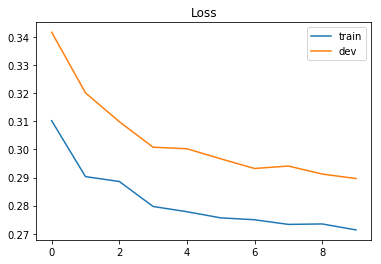

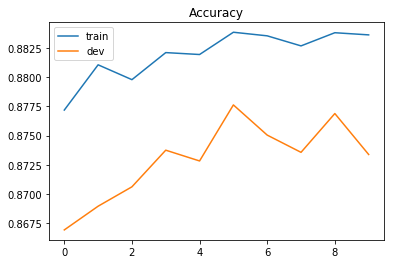

In [7]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

### 预测测试标签

预测测试集的资料标签并且存在 *output_logistic.csv* 中。

In [8]:
# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -4.031960278019251
 Spouse of householder -1.625403958705141
 Other Rel <18 never married RP of subfamily -1.4195759775765404
 Child 18+ ever marr Not in a subfamily -1.2958572076664745
 Unemployed full-time 1.1712558285885912
 Other Rel <18 ever marr RP of subfamily -1.167791807296237
 Italy -1.093458143800618
 Vietnam -1.0630365633146415
num persons worked for employer 0.938992277356651
 1 0.8226614922117185


# 多变量生成模型

接着我们将实作基于 generative model 的二元分类器。

### 数据准备

训练集与测试集的处理方法跟 logistic regression 一模一样，然而因为 generative model 有可解析的最佳解，因此不必使用到 development set。

In [9]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### 平均值和协方差

在 generative model 中，我们需要分别计算两个类别内的资料平均与共变异。

In [10]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

### 计算权重和偏差

权重矩阵与偏差向量可以直接被计算出来。

In [11]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8737466823945739


### 预测测试标签

预测测试集的资料标签并且存在 *output_generative.csv* 中。

In [12]:
# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade 8.53369140625
 34 -6.42578125
 3 -6.400390625
 Abroad 6.171875
 37 -5.86962890625
 Other service -5.5433349609375
 Medical except hospital 5.0693359375
 Child <18 ever marr not in subfamily -5.01025390625
 94 -4.9765625
 32 -4.8916015625
